In [1]:
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree
from sklearn.model_selection import train_test_split

<h3>1. Decision Trees as Interpretable Models
(a) Download the Accute Inflamations data from https://archive.ics.uci.edu/
ml/datasets/Acute+Inflammations.


In [3]:
column = ["a1", "a2", "a3", "a4", "a5", "a6", "d1", "d2"]

In [4]:
df = pd.read_csv("../data/diagnosis.data", encoding="utf-16", header = None, sep='\t', names = column)
df.head()

,a1,a2,a3,a4,a5,a6,d1,d2
0,"35,5",no,yes,no,no,no,no,no
1,"35,9",no,no,yes,yes,yes,yes,no
2,"35,9",no,yes,no,no,no,no,no
3,"36,0",no,no,yes,yes,yes,yes,no
4,"36,0",no,yes,no,no,no,no,no


<h3>(b) Build a decision tree on the whole data set and plot it.1


In [5]:
df['a1'] = df['a1'].str.replace(',','.')

In [6]:
df['a1'] = pd.to_numeric(df['a1'])

In [7]:
for col in column[1:]:
    df[col] = df[col].map({'yes': 1, 'no': 0})

In [8]:
features = df[["a1", "a2", "a3", "a4", "a5", "a6"]]
target = df[[ "d1", "d2"]]

In [9]:
clf = tree.DecisionTreeClassifier()
model = clf.fit(features, target)

In [10]:
text_representation = tree.export_text(clf)
print(text_representation)

|--- feature_0 <= 37.95
|   |--- feature_3 <= 0.50
|   |   |--- class: 0
|   |--- feature_3 >  0.50
|   |   |--- class: 1
|--- feature_0 >  37.95
|   |--- feature_2 <= 0.50
|   |   |--- class: 0
|   |--- feature_2 >  0.50
|   |   |--- feature_1 <= 0.50
|   |   |   |--- class: 0
|   |   |--- feature_1 >  0.50
|   |   |   |--- feature_3 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_3 >  0.50
|   |   |   |   |--- class: 0



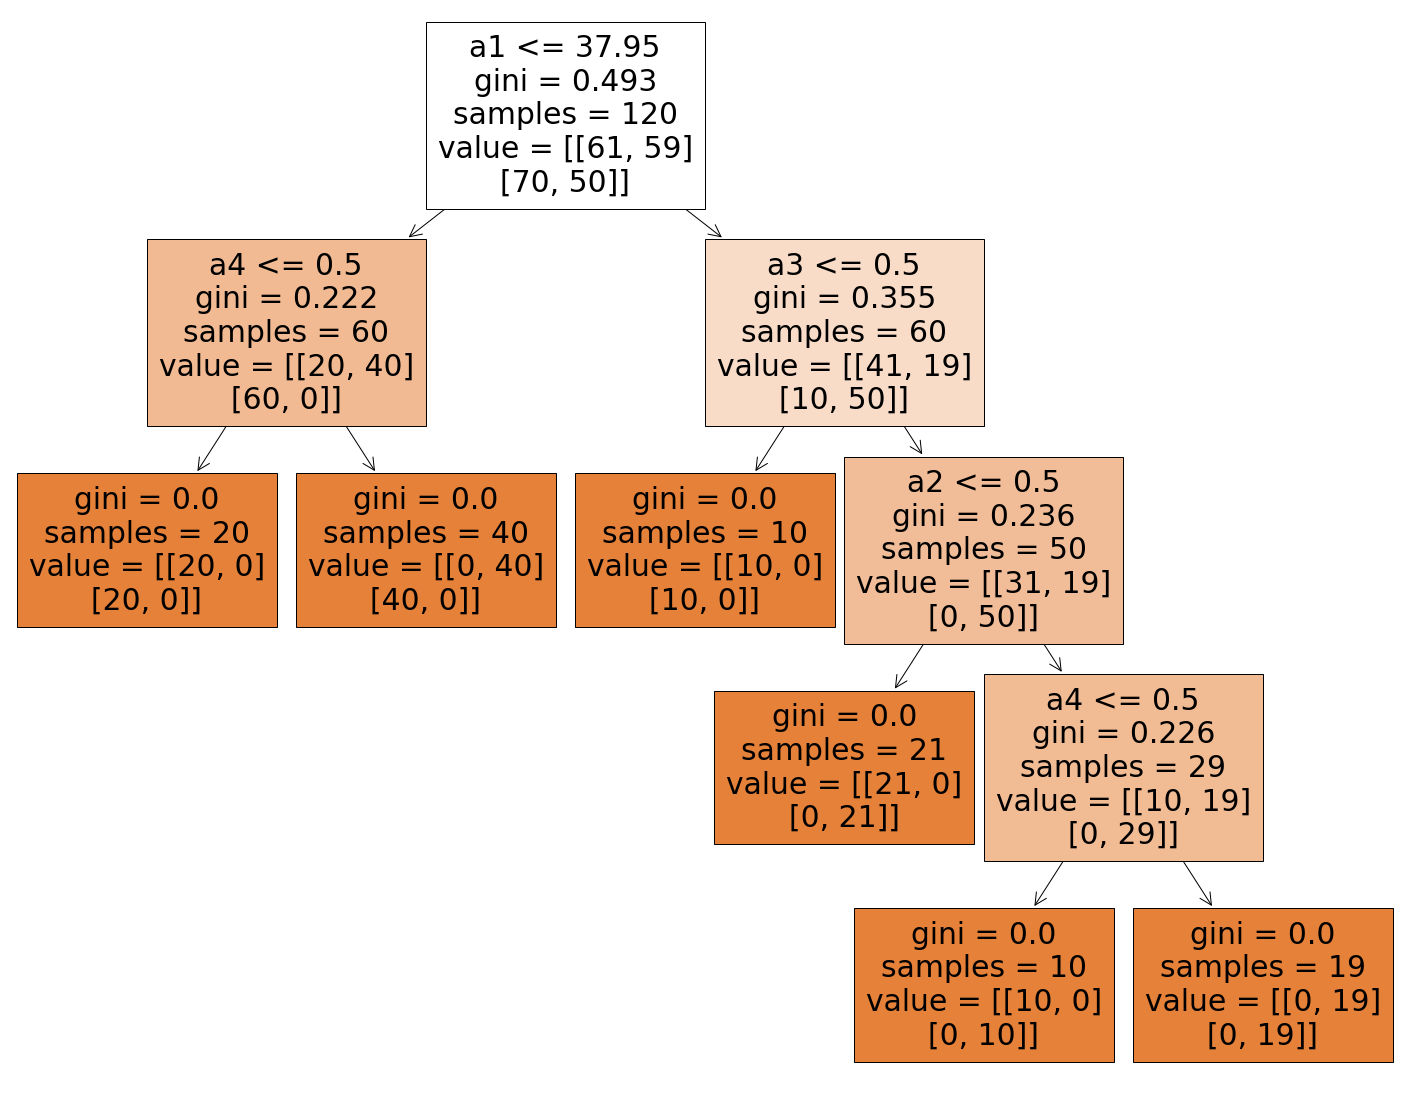

In [11]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, feature_names = features.columns, class_names = target.columns , filled=True)

<h3>(c) Convert the decision rules into a set of IF-THEN rules.2


In [12]:
def tree_to_code(tree, feature_names):

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [13]:
tree_to_code(model, column[:6])

def tree(a1, a2, a3, a4, a5, a6):
  if a1 <= 37.95000076293945:
    if a4 <= 0.5:
      return [[20.  0.]
 [20.  0.]]
    else:  # if a4 > 0.5
      return [[ 0. 40.]
 [40.  0.]]
  else:  # if a1 > 37.95000076293945
    if a3 <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if a3 > 0.5
      if a2 <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else:  # if a2 > 0.5
        if a4 <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else:  # if a4 > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]


In [14]:
def tree_to_pseudo(tree, feature_names):

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} else {")
                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)
                print(indent,"}")
        else:
            print(indent,"return " + str(value[node]))

    recurse(left, right, threshold, features, 0)

In [15]:
tree_to_pseudo(model, column[:6])

 if ( a1 <= 37.95000076293945 ) {
   if ( a4 <= 0.5 ) {
     return [[20.  0.]
 [20.  0.]]
   } else {
     return [[ 0. 40.]
 [40.  0.]]
   }
 } else {
   if ( a3 <= 0.5 ) {
     return [[10.  0.]
 [10.  0.]]
   } else {
     if ( a2 <= 0.5 ) {
       return [[21.  0.]
 [ 0. 21.]]
     } else {
       if ( a4 <= 0.5 ) {
         return [[10.  0.]
 [ 0. 10.]]
       } else {
         return [[ 0. 19.]
 [ 0. 19.]]
       }
     }
   }
 }


<h3>(d) Use cost-complexity pruning to find a minimal decision tree and a set of decision
rules with high interpretability.

In [16]:
trainX, testX, trainy, testy = train_test_split(features, target, test_size = 0.2)

In [17]:
clf = DecisionTreeClassifier()
ccpmodel = clf.cost_complexity_pruning_path(trainX,trainy)

In [18]:
train_accuracy = []
test_accuracy = []
for i in ccpmodel['ccp_alphas']:
    clf = DecisionTreeClassifier(ccp_alpha = i)
    clf.fit(trainX, trainy)
    train_pred = clf.predict(trainX)
    test_pred = clf.predict(testX)
    train_accuracy.append(1-mean_squared_error(trainy, train_pred))
    test_accuracy.append(1-mean_squared_error(testy, test_pred))

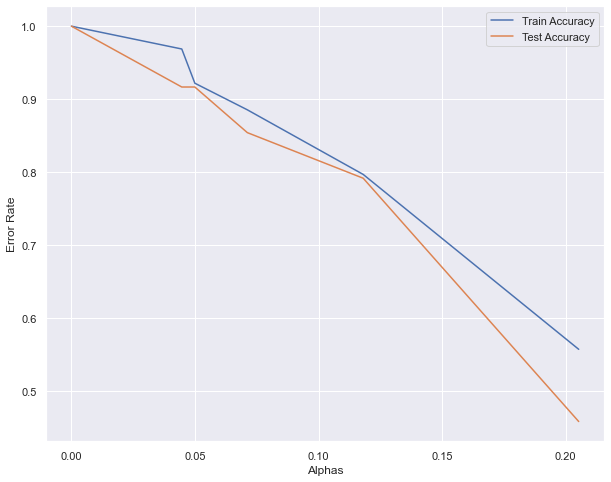

In [19]:
sns.set()
plt.figure(figsize = (10, 8))
sns.lineplot(y = train_accuracy, x = ccpmodel['ccp_alphas'], label = "Train Accuracy")
sns.lineplot(y = test_accuracy, x = ccpmodel['ccp_alphas'], label = "Test Accuracy")
plt.xlabel('Alphas')
plt.ylabel('Error Rate')
plt.show()

In [20]:
clf = DecisionTreeClassifier(ccp_alpha=0, random_state = 40)
model = clf.fit(trainX, trainy)

In [21]:
train_pred = model.predict(trainX)
test_pred = model.predict(testX)
print("Final Training Error: ", mean_squared_error(trainy, train_pred))
print("Final Testing Error: ", mean_squared_error(testy, test_pred))

Final Training Error:  0.0
Final Testing Error:  0.0


In [22]:
tree_to_code(model, column[:6])

def tree(a1, a2, a3, a4, a5, a6):
  if a1 <= 37.95000076293945:
    if a3 <= 0.5:
      return [[ 0. 34.]
 [34.  0.]]
    else:  # if a3 > 0.5
      return [[17.  0.]
 [17.  0.]]
  else:  # if a1 > 37.95000076293945
    if a3 <= 0.5:
      return [[7. 0.]
 [7. 0.]]
    else:  # if a3 > 0.5
      if a5 <= 0.5:
        return [[17.  0.]
 [ 0. 17.]]
      else:  # if a5 > 0.5
        if a4 <= 0.5:
          return [[6. 0.]
 [0. 6.]]
        else:  # if a4 > 0.5
          return [[ 0. 15.]
 [ 0. 15.]]


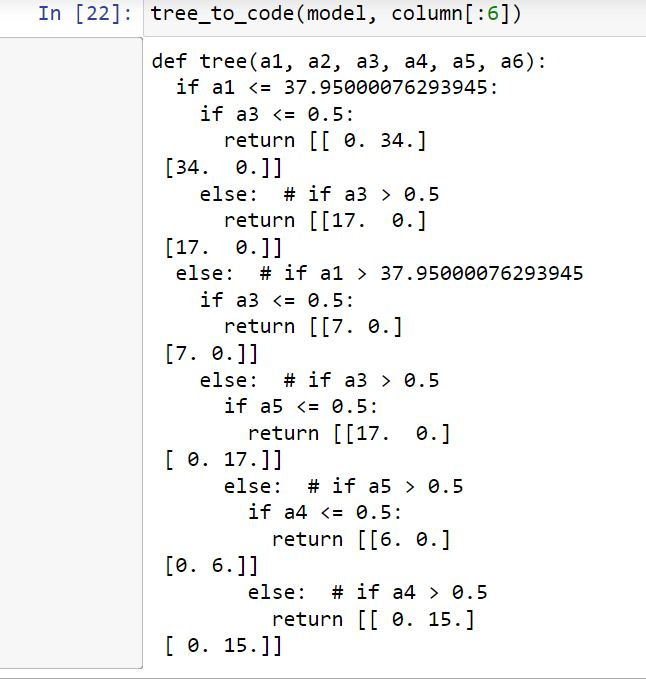

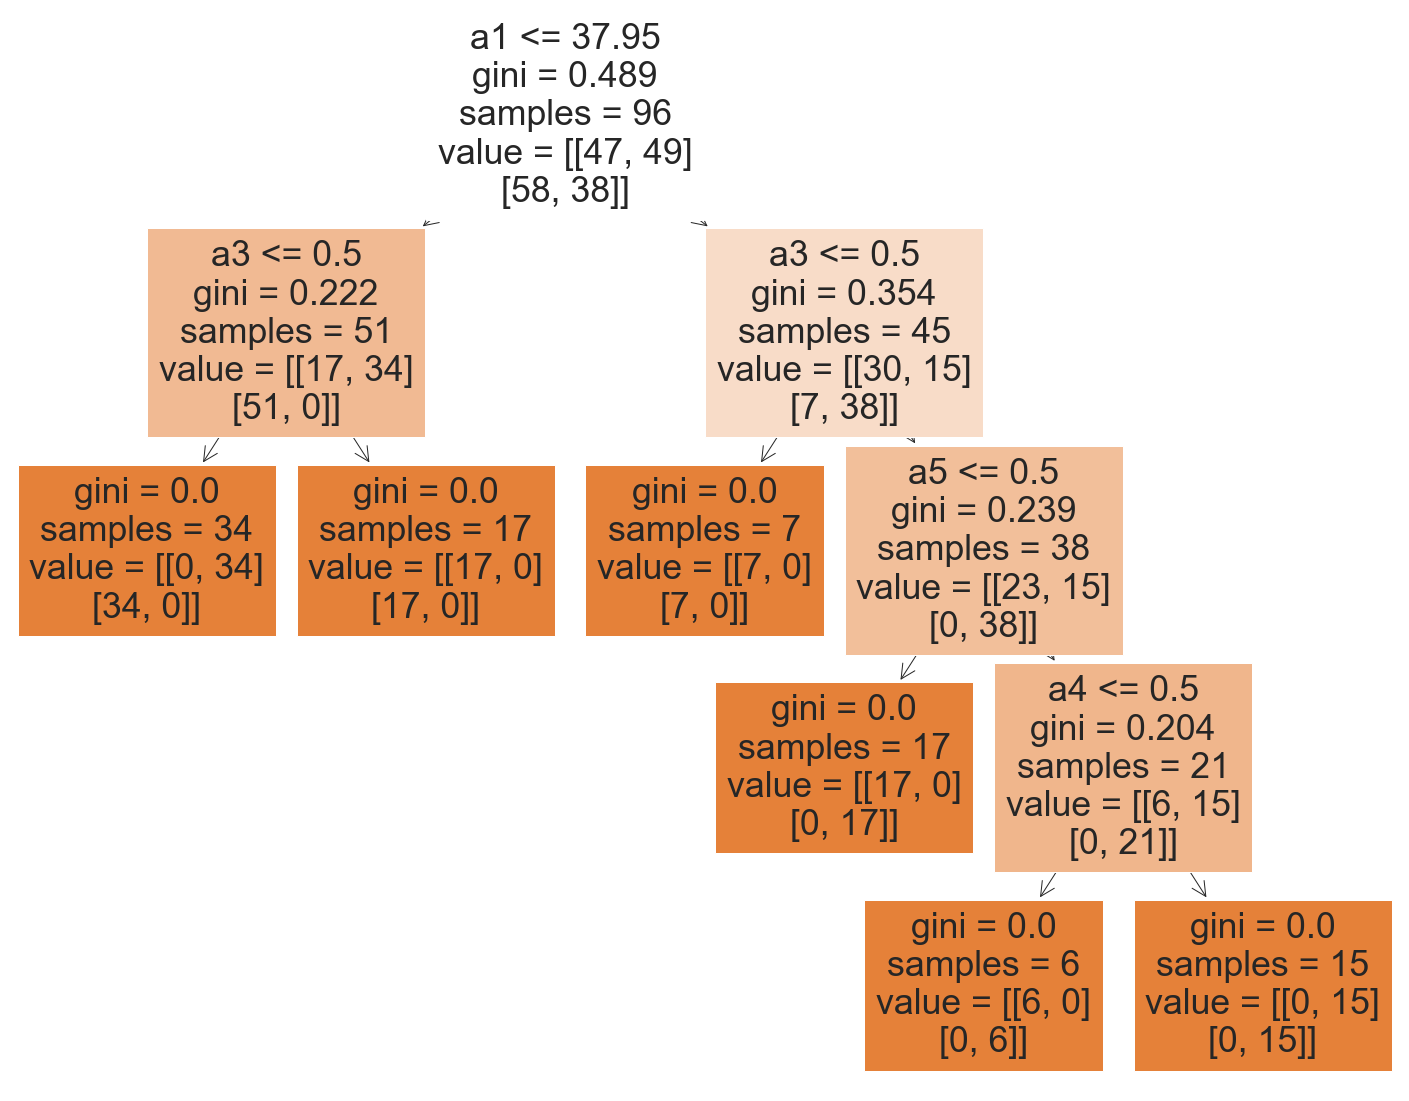

In [23]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, feature_names = features.columns, class_names = target.columns , filled=True)

<h3>
2. The LASSO and Boosting for Regression
(a) Download the Communities and Crime data3
from https://archive.ics.uci.
edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as
the training set and the rest as the test set.


<h3>
(b) The data set has missing values. Use a data imputation technique to deal with
the missing values in the data set. The data description mentions some features
are nonpredictive. Ignore those features.


In [24]:
file = open("../data/communities.names")
data = file.readlines()

In [25]:
columns = []
for i in range(75, 203):
    col = data[i].split()
    columns.append(col[1])

In [26]:
df = pd.read_csv("../data/communities.data", header = None, names = columns)
df.iloc[:, 5:] = df.iloc[:, 5:].replace('?',np.nan)
df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [27]:
features = df.iloc[:, 5:]

In [28]:
train = features.iloc[:1495]
test = features.iloc[1495:]
#testy = features['ViolentCrimesPerPop'].iloc[1495:]

In [29]:
impute_data = SimpleImputer(strategy='mean')
train.iloc[:, 5:] = impute_data.fit_transform(train.iloc[:, 5:])
test.iloc[:, 5:] = impute_data.fit_transform(test.iloc[:, 5:])

In [30]:
features = pd.concat([train,test])

<h3>
(c) Plot a correlation matrix for the features in the data set.



In [31]:
features.iloc[:, :122].corr()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
population,1.000000,-0.046148,0.231178,-0.300845,0.181603,0.156218,0.006368,0.130344,0.075596,-0.102006,...,0.110869,0.713652,0.231897,0.270356,0.609025,0.591863,-0.060176,0.075756,0.466352,-0.035108
householdsize,-0.046148,1.000000,-0.067109,-0.235907,0.201996,0.468659,0.520461,0.367338,0.295225,-0.612666,...,0.027574,-0.015078,-0.004072,-0.051506,-0.032958,-0.009528,-0.011031,-0.002349,-0.094368,-0.052340
racepctblack,0.231178,-0.067109,1.000000,-0.794389,-0.106738,-0.066581,0.122338,0.153475,0.134068,0.052934,...,-0.049673,0.149758,0.095053,0.147023,0.121997,0.082672,-0.079922,0.010885,0.260793,0.022149
racePctWhite,-0.300845,-0.235907,-0.794389,1.000000,-0.270266,-0.444166,-0.194015,-0.266852,-0.183804,0.136483,...,-0.026724,-0.131389,-0.337458,-0.215636,-0.109236,-0.114599,0.050180,-0.033414,-0.276234,-0.005907
racePctAsian,0.181603,0.201996,-0.106738,-0.270266,1.000000,0.266743,-0.025020,0.100727,0.052761,-0.272020,...,0.126550,-0.001084,0.389944,0.296921,-0.018025,0.067119,0.030704,0.064770,0.101888,-0.011324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PolicOperBudg,0.591863,-0.009528,0.082672,-0.114599,0.067119,0.060512,-0.019269,0.011067,-0.001448,-0.020628,...,0.141440,0.395093,0.130144,0.172266,0.799408,1.000000,-0.058583,0.034917,-0.062375,0.245440
LemasPctPolicOnPatr,-0.060176,-0.011031,-0.079922,0.050180,0.030704,0.024973,-0.003476,0.009213,0.012742,0.019504,...,0.094272,-0.071618,0.053388,0.026682,-0.107241,-0.058583,1.000000,0.035644,0.020296,-0.254718
LemasGangUnitDeploy,0.075756,-0.002349,0.010885,-0.033414,0.064770,0.026412,0.009440,0.003542,-0.001200,-0.036443,...,0.137413,0.106469,-0.076351,-0.080706,0.079727,0.034917,0.035644,1.000000,-0.015673,-0.032356
LemasPctOfficDrugUn,0.466352,-0.094368,0.260793,-0.276234,0.101888,0.125353,0.001301,0.117290,0.083180,-0.010168,...,-0.027008,0.299632,0.228084,0.206644,-0.052428,-0.062375,0.020296,-0.015673,1.000000,0.018603


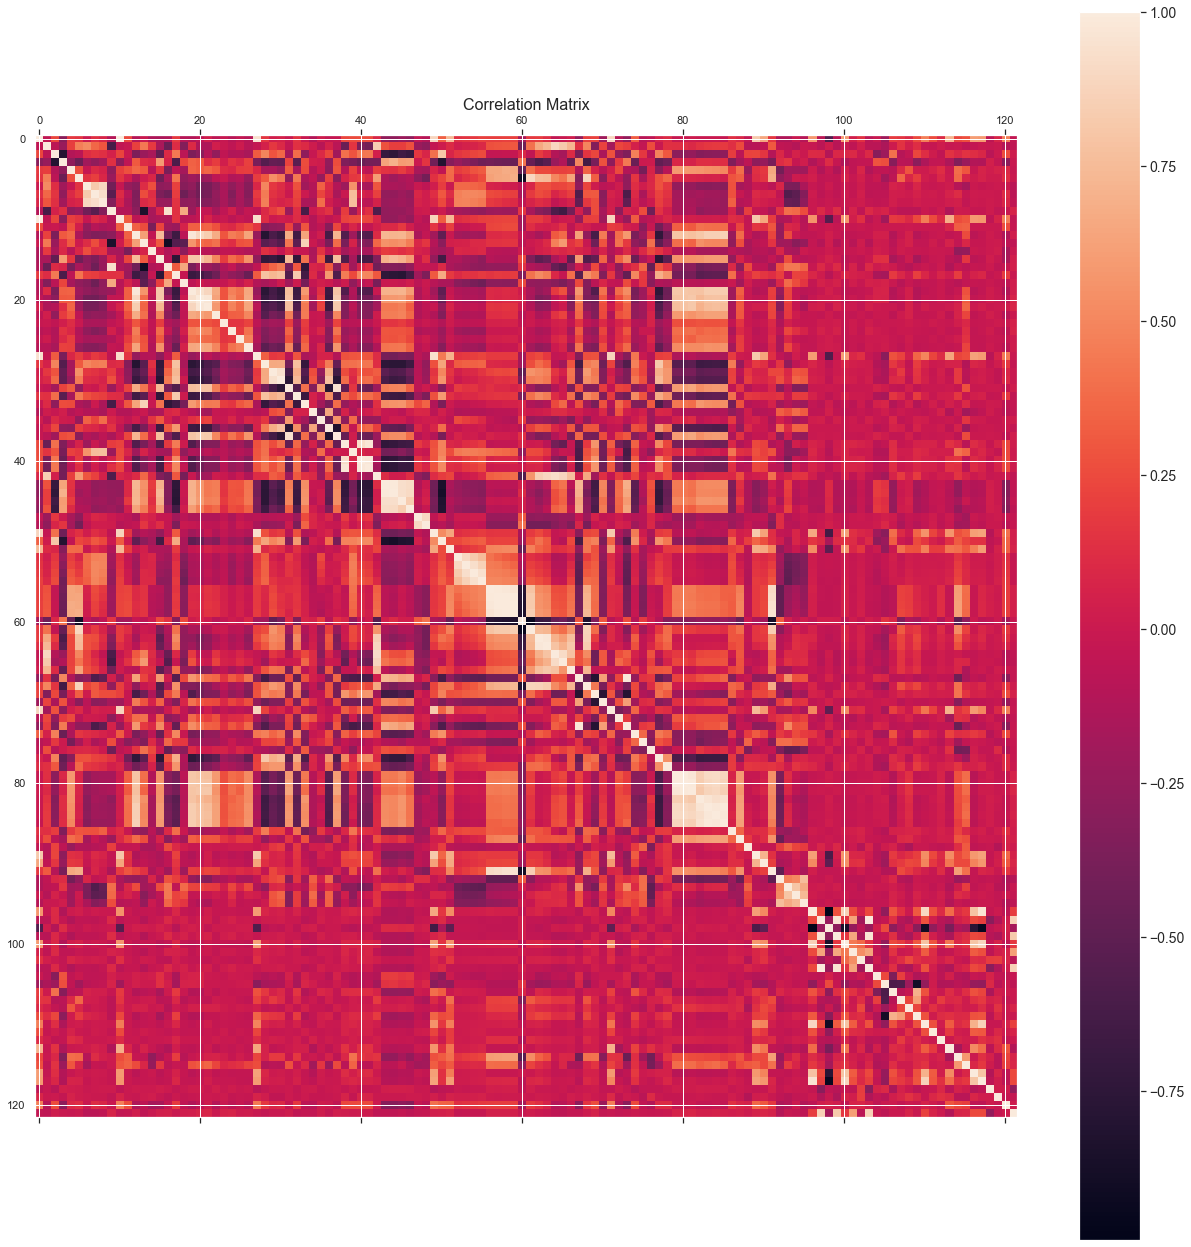

In [32]:
f = plt.figure(figsize=(22, 22))
plt.matshow(features.iloc[:, :122].corr(),fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

<h3>
(d) Calculate the Coefficient of Variation CV for each feature, where CV =
s
m
, in
which s is sample standard deviation and m is sample mean..

In [60]:
import math

In [61]:
dictionary = {}
for col in features.columns:
    dictionary[col] = math.sqrt(features[col].var())/features[col].mean()

In [63]:
newcvdf = pd.DataFrame(dictionary.items(), columns=['Columns', 'Score_CV'])
newcvdf.head()

,Columns,Score_CV
0,population,2.203503
1,householdsize,0.353298
2,racepctblack,1.410920
3,racePctWhite,0.323782
4,racePctAsian,1.359162


In [64]:
sorted_newcvdf = newcvdf.sort_values(by = ['Score_CV'], ascending=False)
sorted_newcvdf.head()

,Columns,Score_CV
90,NumStreet,4.407702
89,NumInShelters,3.485481
49,NumIlleg,2.994196
51,NumImmig,2.900497
120,LemasPctOfficDrugUn,2.555266


<h3>
(e) Pick b
√
128c features with highest CV , and make scatter plots and box plots for
them. Can you draw conclusions about significance of those features, just by the
scatter plots?


In [65]:
cv_features = list(sorted_newcvdf[:int(np.sqrt(128))]['Columns'])
cv_df = features[cv_features]
cv_df

,NumStreet,NumInShelters,NumIlleg,NumImmig,LemasPctOfficDrugUn,NumUnderPov,population,numbUrban,HousVacant,LandArea,racePctHisp
0,0.00,0.04,0.04,0.03,0.32,0.08,0.19,0.20,0.21,0.12,0.17
1,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.02,0.02,0.02,0.07
2,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.04
3,0.00,0.00,0.03,0.02,0.00,0.01,0.04,0.06,0.01,0.02,0.10
4,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.01,0.04,0.05
...,...,...,...,...,...,...,...,...,...,...,...
1989,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.03,0.02,0.01,0.16
1990,0.00,0.01,0.03,0.05,0.00,0.04,0.05,0.06,0.03,0.02,0.32
1991,0.02,0.06,0.13,0.06,0.91,0.12,0.16,0.17,0.21,0.08,0.25
1992,0.01,0.04,0.02,0.06,0.22,0.03,0.08,0.09,0.05,0.03,0.10


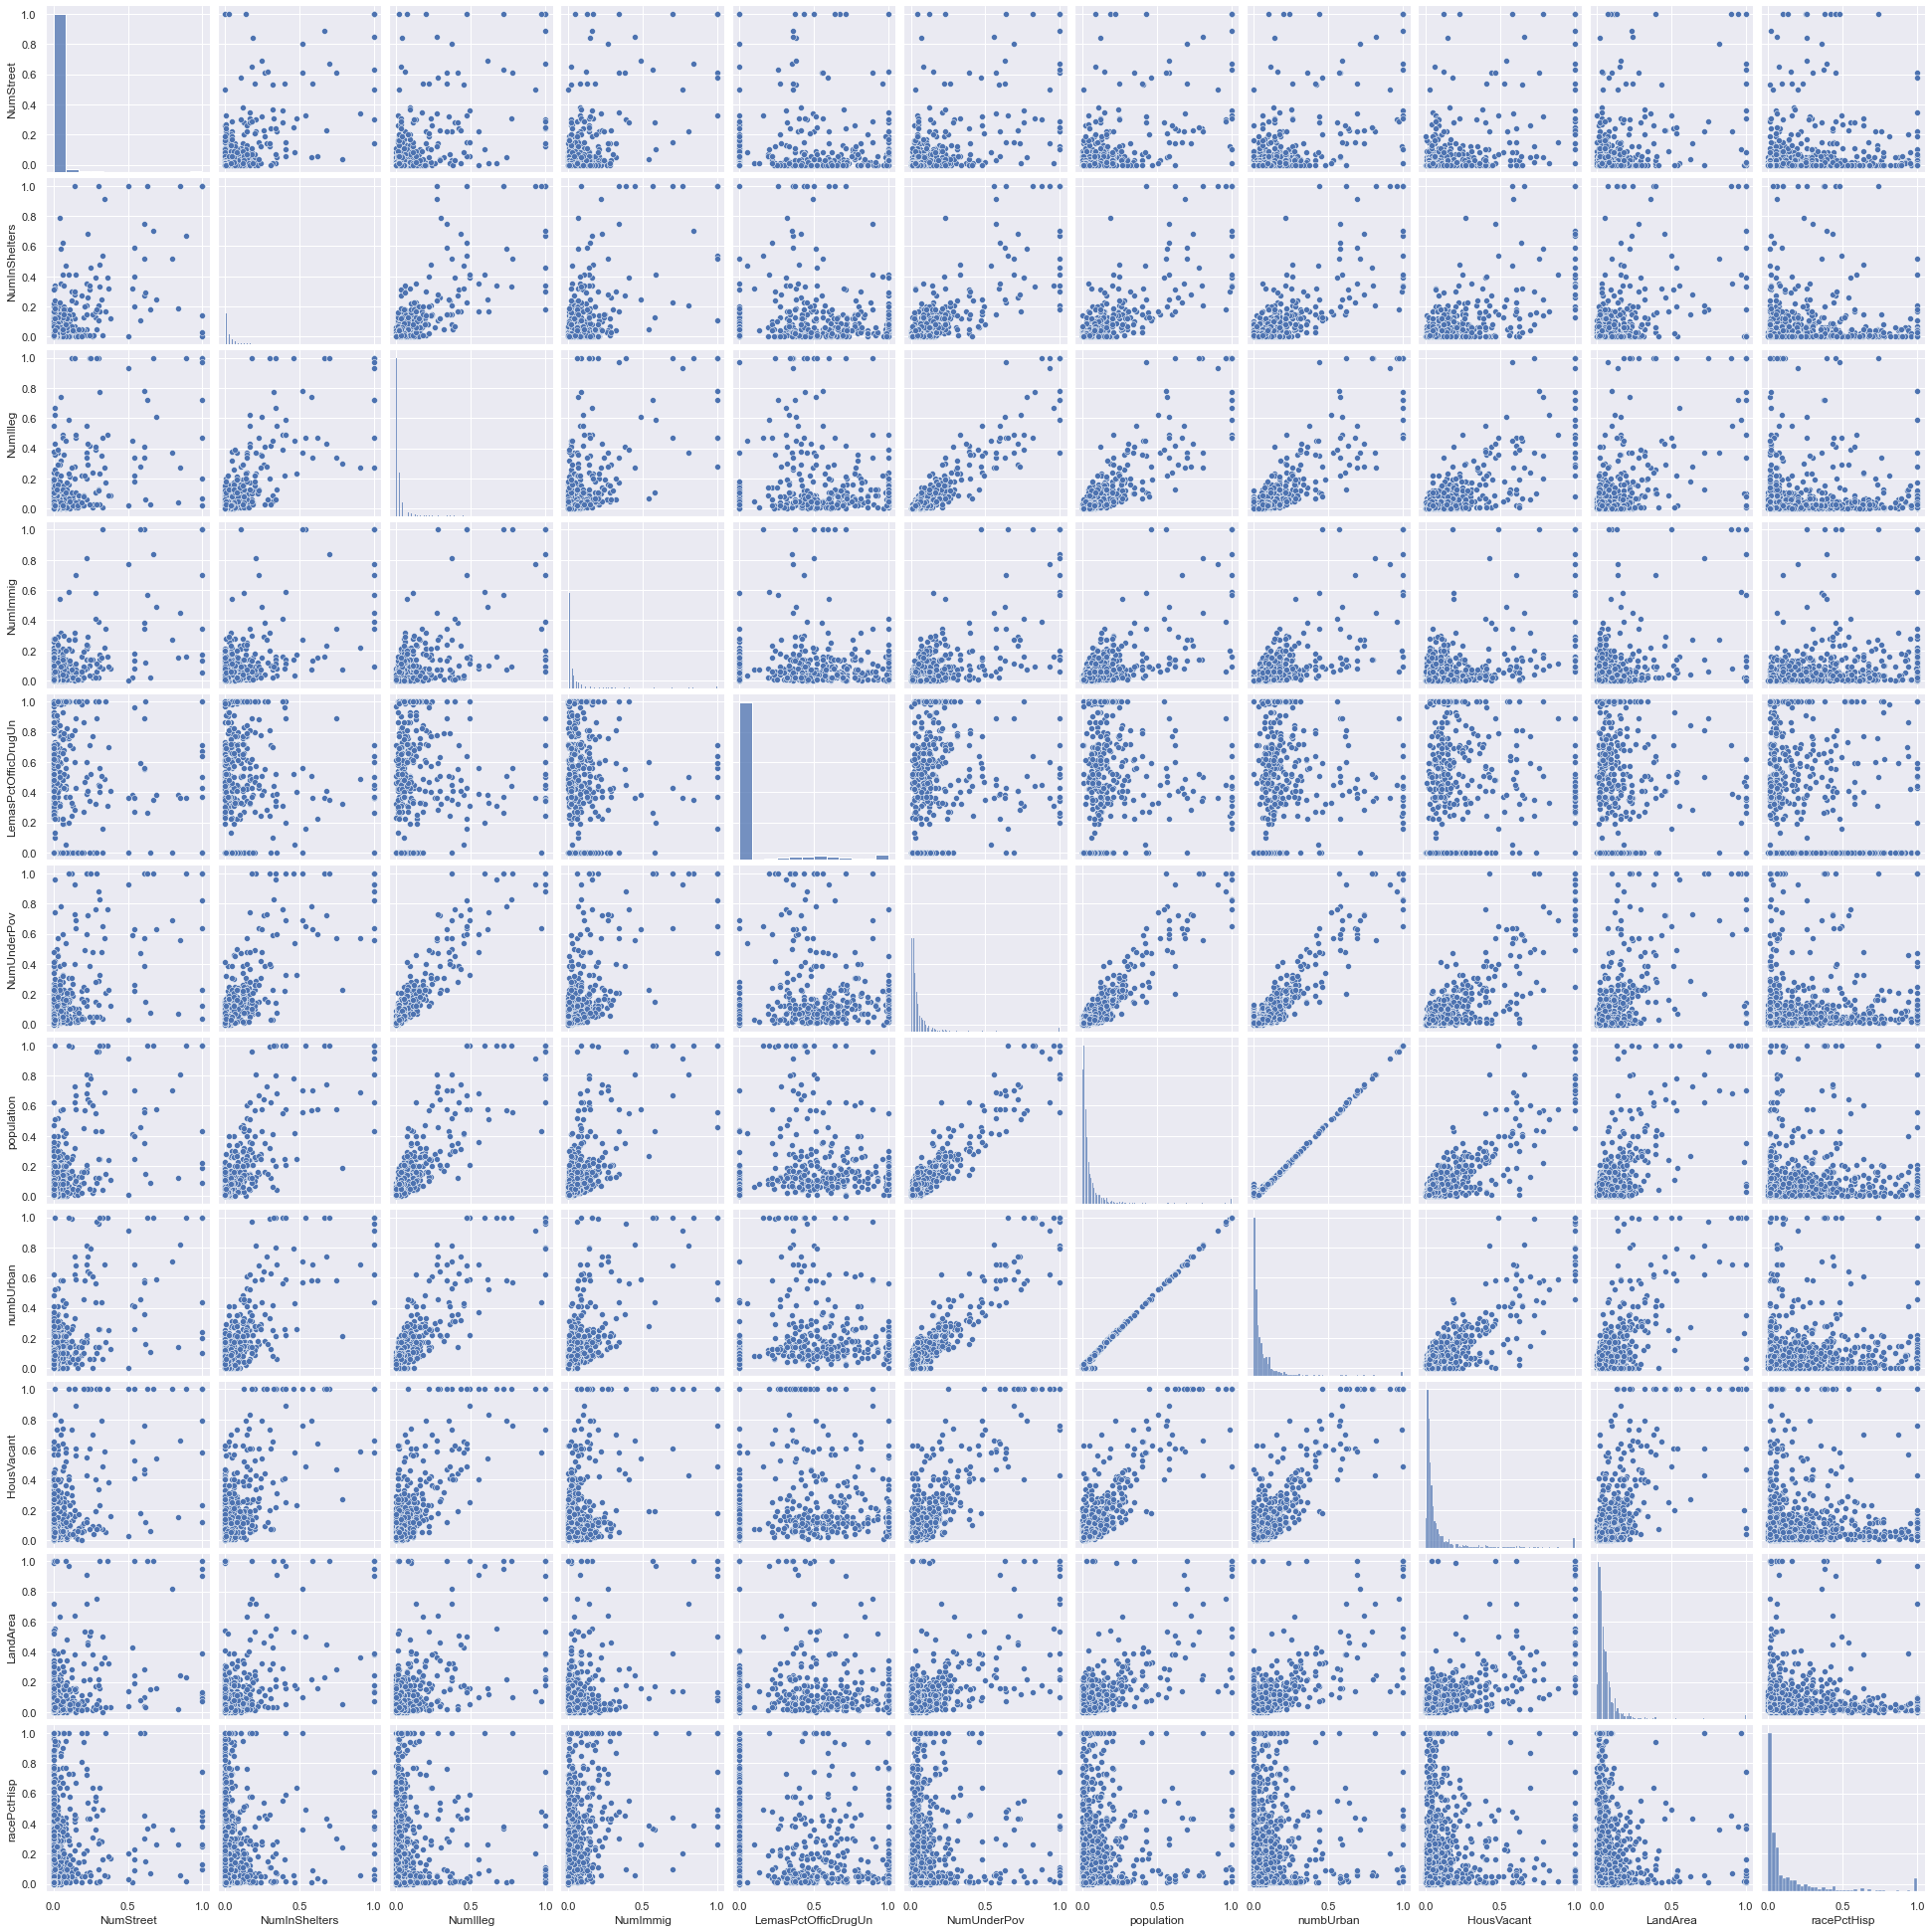

In [36]:
sns.pairplot(cv_df)

[]

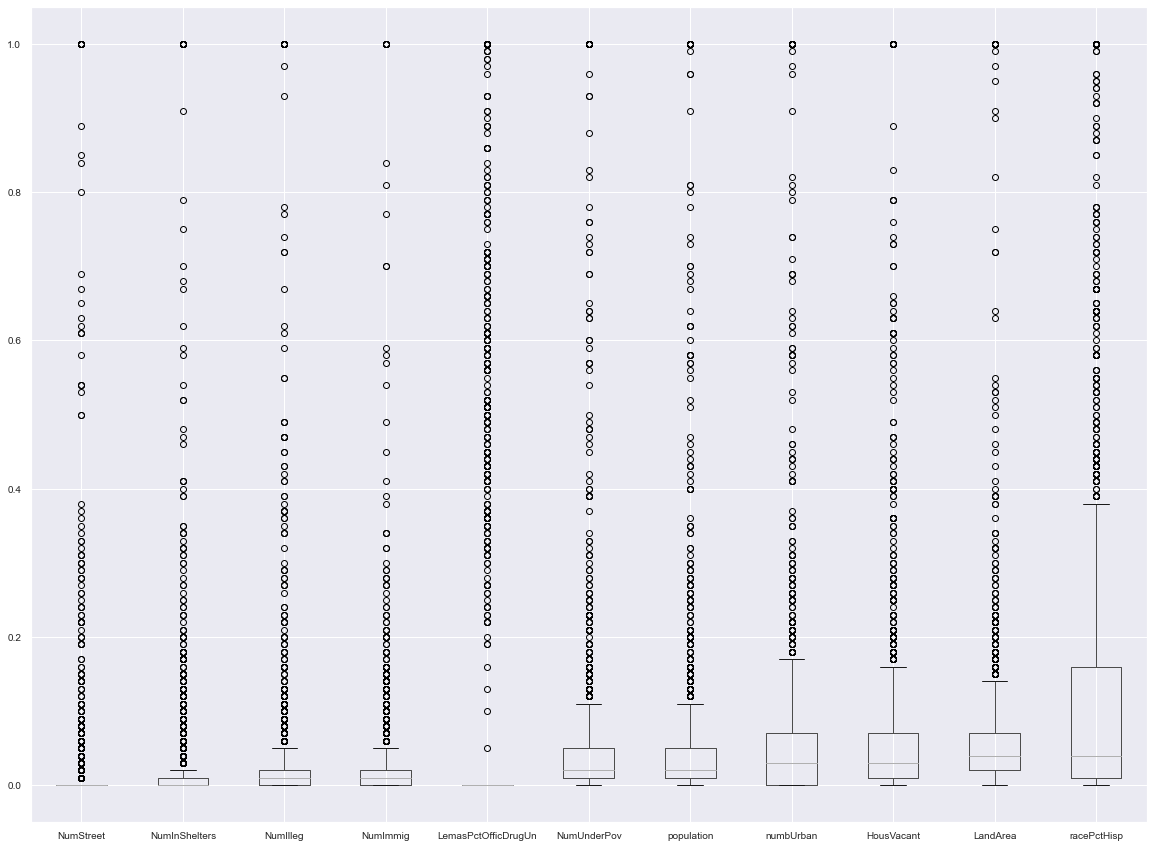

In [37]:
boxplot = cv_df.boxplot(column=cv_features, figsize=(20, 15), fontsize=10)
boxplot.plot()

<h4>Conclusion

Numburban and Population show linear relation

<h3>
(f) Fit a linear model using least squares to the training set and report the test error.


In [38]:
trainX = features.iloc[:1495, :122]
trainy = features['ViolentCrimesPerPop'].iloc[:1495]
testX = features.iloc[1495:, :122]
testy = features['ViolentCrimesPerPop'].iloc[1495:]

In [39]:
trainX.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.290000,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.323598,0.02,0.12,0.45,0.163975,0.080502,0.713054,0.451883,0.00,0.190753
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.323598,0.01,0.21,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.323598,0.02,0.39,0.28,0.163975,0.080502,0.713054,0.451883,0.00,0.190753
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.323598,0.04,0.09,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753


In [40]:
linearmodel = LinearRegression()
linearmodel = linearmodel.fit(trainX, trainy)
predict_y = linearmodel.predict(testX)
print("The test error for the linear model", mean_squared_error(testy, predict_y))

The test error for the linear model 1.519109735076951e+18


<h3>
(g) Fit a ridge regression model on the training set, with λ chosen by cross-validation.
Report the test error obtained.


In [41]:
ridge = RidgeCV(alphas = np.arange(0.1, 1, 100))
ridge = ridge.fit(trainX, trainy)
print('Alpha selected based on Cross Validation Accuracy:', ridge.alpha_)

Alpha selected based on Cross Validation Accuracy: 0.1


In [42]:
ridge = RidgeCV(alphas = ridge.alpha_)
ridge = ridge.fit(trainX, trainy)
predict_y = ridge.predict(testX)
print("Final Test Error: ", mean_squared_error(testy, predict_y))

Final Test Error:  0.017947085214095642


<h3>
(h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report
the test error obtained, along with a list of the variables selected by the model.
Repeat with standardized4
features. Report the test error for both cases and
compare them.


In [43]:
lasso=LassoCV(alphas = np.linspace(-0.03, 1, 100), cv = 5)
lasso=lasso.fit(trainX, trainy)
print('Alpha selected based on Cross Validation Accuracy:', lasso.alpha_)

Alpha selected based on Cross Validation Accuracy: 0.0012121212121212165


In [44]:
lasso = Lasso(alpha = lasso.alpha_)
lasso = lasso.fit(trainX, trainy)
predict_y = lasso.predict(testX)
print("Final Test Error: ", mean_squared_error(testy, predict_y))

Final Test Error:  0.01758212221303194


In [45]:
column_names = features.iloc[:, :122].columns
print("Final features selected:")
for i in range(len(lasso.coef_)):
    if lasso.coef_[i] != 0:
        print(column_names[i])

Final features selected:
racepctblack
racePctWhite
pctUrban
pctWPubAsst
AsianPerCap
MalePctDivorce
PctKids2Par
PctYoungKids2Par
PctWorkMom
PctIlleg
PctRecImmig10
PctPersDenseHous
HousVacant
PctHousOccup
PctVacantBoarded
MedRentPctHousInc
MedOwnCostPctIncNoMtg
NumStreet
PctForeignBorn
LemasGangUnitDeploy
LemasPctOfficDrugUn


In [46]:
std_scaler = preprocessing.StandardScaler().fit(trainX)
newtrainX = std_scaler.transform(trainX)
new_lasso = LassoCV(alphas = np.linspace(-0.03, 1, 100), cv = 5)
new_lasso = new_lasso.fit(newtrainX, trainy)
print('Alpha selected based on Cross Validation Accuracy:', new_lasso.alpha_)

Alpha selected based on Cross Validation Accuracy: 0.0012121212121212165


In [47]:
std_scaler = preprocessing.StandardScaler().fit(testX)
newtestX = std_scaler.transform(testX)
test_lasso = Lasso(alpha = new_lasso.alpha_)
test_lasso = test_lasso.fit(newtrainX, trainy)
predict_y = test_lasso.predict(newtestX)
print("Final Test Error: ", mean_squared_error(testy, predict_y))

Final Test Error:  0.017925346315589695


In [48]:
print("Final features selected:")
for i in range(len(test_lasso.coef_)):
    if test_lasso.coef_[i] != 0:
        print(column_names[i])

Final features selected:
racepctblack
agePct12t21
agePct12t29
pctUrban
pctWWage
pctWFarmSelf
pctWInvInc
pctWSocSec
pctWPubAsst
pctWRetire
blackPerCap
indianPerCap
AsianPerCap
OtherPerCap
HispPerCap
PctPopUnderPov
PctEmploy
MalePctDivorce
MalePctNevMarr
PctKids2Par
PctYoungKids2Par
PctTeen2Par
PctWorkMom
PctIlleg
NumImmig
PctImmigRec5
PctRecImmig10
PctPersOwnOccup
PctPersDenseHous
PctHousLess3BR
HousVacant
PctHousOccup
PctVacantBoarded
PctVacMore6Mos
MedYrHousBuilt
PctWOFullPlumb
RentLowQ
MedRent
MedRentPctHousInc
MedOwnCostPctIncNoMtg
NumInShelters
NumStreet
PctForeignBorn
PctSameCity85
LemasSwFTFieldPerPop
LemasTotalReq
PolicReqPerOffic
RacialMatchCommPol
PctPolicBlack
PctPolicAsian
OfficAssgnDrugUnits
NumKindsDrugsSeiz
PolicAveOTWorked
LandArea
PopDens
PctUsePubTrans
PolicCars
LemasPctPolicOnPatr
LemasGangUnitDeploy
PolicBudgPerPop


<h4> Comaprision: Standardized Lasso Test error is a bit more than normal lasso test error

<h3>
(i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.


In [49]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

In [50]:
pca = PCA()
pc_values = pca.fit_transform(trainX)

In [70]:
pcalist = [['pca_selected_features','meansquarederror','M_pca']]

for i in range(1, len(column_names)):
    cross_val = cross_val_score(estimator=LinearRegression(), X = pc_values[:, :i], y = trainy, cv = 10, scoring="neg_mean_squared_error").mean()*(-1)
    l = [column_names[i], cross_val, i]
    pcalist.append(l)

In [73]:
pca_df = pd.DataFrame(pcalist[1:], columns = pcalist[0])
pca_df.head()
M = pca_df['meansquarederror'].idxmin() + 1
print('Total features Selected', M)

Total features Selected 96


In [74]:
pca = PCA(n_components=M)
pc_values = pca.fit_transform(trainX)
lr = LinearRegression().fit(trainX.iloc[:, :M], trainy)
pred_y = lr.predict(testX.iloc[:, :M])
print("Final Test Error:", mean_squared_error(testy, pred_y))

Final Test Error: 0.017683626316658953


<h3>(j) In this section, we would like to fit a boosting tree to the data. As in classification
trees, one can use any type of regression at each node to build a multivariate
regression tree. Because the number of variables is large in this problem, one
can use L1-penalized regression at each node. Such a tree is called L1 penalized
gradient boosting tree. You can use XGBoost5
to fit the model tree. Determine
α (the regularization term) using cross-validation.

In [54]:
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV

In [55]:
alpha_values=np.linspace(-1, 1, 100)
xgboost = xgb.XGBRegressor(objective='reg:squarederror')
xgboost = GridSearchCV(xgboost, {'reg_alpha': alpha_values}, cv = 10)
xgboost = xgboost.fit(trainX, trainy)
print('Alpha selected:', xgboost.best_params_['reg_alpha'])

Alpha selected: 0.8989898989898992


In [56]:
newxgboost = xgb.XGBRegressor(objective='reg:squarederror', reg_alpha=xgboost.best_params_['reg_alpha'])
newxgboost = newxgboost.fit(trainX, trainy)
pred_y = newxgboost.predict(testX)
print("Final Test Error:", mean_squared_error(testy, pred_y))

Final Test Error: 0.01803330249584083
